In [3]:
%pylab notebook

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec, dotproduct_crispr_spec, dotproduct_linearized

from primo.models.encoder import entropy_regularizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mhrlkllb because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [4]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=5*10**4
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75
# Intuitively determined:
batch_size = 20
val_batch_size = 150


def keras_batch_generator(dataset_batch_generator):
    # Yield datasets
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, triplets = next(dataset_batch_generator)
        yield triplets, np.zeros(len(triplets))

train_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        train_dataset.random_features(batch_size),
        similarity_threshold
    )
)

val_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        validation_dataset.random_features(val_batch_size),
        similarity_threshold
    )
)


train_inputs, train_targets = next(train_batch_generator)

switching to train_f.h5 and train_4.h5


In [9]:
OUTPUT_LEN = 40

GUMBEL_SOFTMAX_TEMP = 0.5

def sample_gumbel(shape, eps=1e-20):
    U = tf.random.uniform(shape, minval=0, maxval=1)
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax(temperature, hard):
    def gumbel_softmax_f(x):
        gumbel_softmax_sample = x# + sample_gumbel(tf.shape(x))        
        y = tf.nn.softmax(gumbel_softmax_sample / temperature)
        if hard:
            y_hard = tf.one_hot(tf.argmax(y, -1), 4)
            y = tf.stop_gradient(y_hard - y) + y
        return y
    return gumbel_softmax_f

def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        #return tf.reduce_max(scores, axis=0)
        #return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        return 1 - tf.reduce_prod(1 - scores, axis=0)

    return multisite_predict

def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(dotproduct_crispr_spec), sites)
    linear_scores = 10**scores
    return tf.experimental.numpy.log10(tf.reduce_sum(linear_scores, axis=0))
    #return tf.reduce_max(scores, axis=0)

encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(2048, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    #layers.Activation('softmax'),
    layers.Lambda(gumbel_softmax(GUMBEL_SOFTMAX_TEMP, True)),
], name='encoder')

#encoder = tf.keras.models.load_model('/tf/primo/data/models/exp_encoder_8.h5')

# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(1024, activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')

X_triplets = layers.Input([3, 4096])

# Essentially, we started with ]a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2, X3 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:], X[:,2,:]))(X_triplets)

distances = layers.Lambda(lambda Xs:
                          (
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)),
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[2]), axis=1))
                          ))([X1,X2,X3])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)
S3 = encoder(X3)

# Glue them back together! Back into a batch of feature vector pairs.
S_triplets = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2,S3])

# Dimensions: (batch_size x 80 x 4 x 3 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 3 x DNA length x 4)
S_triplets_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_triplets)

encoder_trainer = tf.keras.Model(inputs=X_triplets, outputs=S_triplets_T)
encoder.load_weights('/tf/primo/data/models/encoder_2site_triplet_20210131_1.h5')

print(encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 160)               327840    
_________________________________________________________________
reshape_1 (Reshape)          (None, 40, 4)             0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 40, 4)             0   

In [10]:
import secrets
import os
def UniquenessMetric(y_true, y_pred):
    """Use a single batch of inputs to measure sequence uniqueness while training"""
    seqs = encoder_trainer(train_inputs)
    # Reduce seqs to a single base (e.g. [0.6, 0.2, 0.1, 0.1] -> [0])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    # Now each sample is array of 20 integers, 0-3. Multiply each position by 4**n to make
    # a unique integer for each possible 20bp sequence
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    #hashed_seqs = tf.reduce_sum(rounded_seqs * (4 ** tf.range(0, 20, dtype=tf.int64)), axis=-1)
    # Get unique ones
    #unique_seqs, _ = tf.unique(hashed_seqs)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

    
def ConfidenceMetric(batch):
    """Uses a single batch of inputs to measure sequence uniqueness while training"""
    def confidence(_y_true, y_pred):
        seqs = y_pred[:, 0, :, :]
        # Get the highest probabilty value for each base
        max_seqs = tf.reduce_max(seqs, axis=-1)
        # Take mean along both batch and seqence dimensions
        return tf.reduce_mean(max_seqs)
    return confidence

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

def RecallMetric(y_true, y_pred):
    Yp = log_multisite_predictor(tf.gather(y_pred, [0, 1], axis=1))
    return tf.reduce_mean(tf.cast(Yp > -2.0, tf.float32))

def NegRecallMetric(y_true, y_pred):
    Yn = log_multisite_predictor(tf.gather(y_pred, [0, 2], axis=1))
    return tf.reduce_mean(tf.cast(Yn > -2.0, tf.float32))
            
class TripletLoss(object):
    def __init__(self, margin):
        self.margin = margin
    
    def __call__(self, y_true, y_pred):
        """
        y_pred is triplets of (anchor, positive, negative), with dimensions
        batch_size x 3 x 20 x 4
        """
#         pos_distance = 1-linear_crispr_spec(-1.8)(tf.gather(y_pred, [0,1], axis=1))
#         neg_distance = linear_crispr_spec(-1.8)(tf.gather(y_pred, [0,2], axis=1))
        
        pos_distance = -log_multisite_predictor(tf.gather(y_pred, [0,1], axis=1))
        neg_distance = log_multisite_predictor(tf.gather(y_pred, [0,2], axis=1))
#         pos_distance = -tfp.math.clip_by_value_preserve_gradient(pos_distance, -3.7, 0)
#         neg_distance = -tfp.math.clip_by_value_preserve_gradient(neg_distance, -3.7, 0)
        
        return tf.maximum(pos_distance, 0.5) + tf.maximum(neg_distance, -3.0)
        #return pos_distance - neg_distance + self.margin
        #return tf.maximum(pos_distance - 2*neg_distance + self.margin, 0.0)
        #return neg_distance - pos_distance

    

In [11]:
### 
# Train with full dataset
####
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-2),
    TripletLoss(0.9),
    run_eagerly=True,
    metrics=[UniquenessMetric, RecallMetric, NegRecallMetric,])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=100,
    epochs=500,
    callbacks=[EarlyStopCallback()],
)

Touch /tf/primo/signals/2e66 to terminate training early
Epoch 1/500
100/100 [==============================] - 76s 761ms/step - loss: -0.9413 - UniquenessMetric: 0.9655 - RecallMetric: 0.8930 - NegRecallMetric: 0.5020 - val_loss: -1.1906 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4187
Epoch 2/500
100/100 [==============================] - 65s 654ms/step - loss: -0.8861 - UniquenessMetric: 0.8610 - RecallMetric: 0.8970 - NegRecallMetric: 0.5150 - val_loss: -1.2983 - val_UniquenessMetric: 0.9000 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.3907
Epoch 3/500
100/100 [==============================] - 66s 657ms/step - loss: -0.8511 - UniquenessMetric: 0.9485 - RecallMetric: 0.9005 - NegRecallMetric: 0.5335 - val_loss: -0.8798 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9547 - val_NegRecallMetric: 0.6027
Epoch 4/500
100/100 [==============================] - 66s 658ms/step - loss: -0.8866 - UniquenessMetric: 0.8990 - RecallMetric: 0.91

Epoch 22/500
100/100 [==============================] - 66s 660ms/step - loss: -0.8858 - UniquenessMetric: 0.8100 - RecallMetric: 0.9190 - NegRecallMetric: 0.5180 - val_loss: -0.8396 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.5280
Epoch 23/500
100/100 [==============================] - 66s 659ms/step - loss: -0.8536 - UniquenessMetric: 0.8185 - RecallMetric: 0.9100 - NegRecallMetric: 0.5190 - val_loss: -0.9110 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5240
Epoch 24/500
100/100 [==============================] - 66s 661ms/step - loss: -0.9302 - UniquenessMetric: 0.8015 - RecallMetric: 0.8785 - NegRecallMetric: 0.4740 - val_loss: -0.9569 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4680
Epoch 25/500
100/100 [==============================] - 66s 659ms/step - loss: -0.8823 - UniquenessMetric: 0.8540 - RecallMetric: 0.8870 - NegRecallMetric: 0.4585 - val_loss: -0.9193 - va

Epoch 49/500
100/100 [==============================] - 66s 665ms/step - loss: -0.7613 - UniquenessMetric: 0.8550 - RecallMetric: 0.8755 - NegRecallMetric: 0.4820 - val_loss: -0.7681 - val_UniquenessMetric: 0.9000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5520
Epoch 50/500
100/100 [==============================] - 66s 663ms/step - loss: -0.8293 - UniquenessMetric: 0.8580 - RecallMetric: 0.8895 - NegRecallMetric: 0.4715 - val_loss: -0.8174 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9480 - val_NegRecallMetric: 0.5267
Epoch 51/500
100/100 [==============================] - 76s 765ms/step - loss: -0.9021 - UniquenessMetric: 0.8130 - RecallMetric: 0.8990 - NegRecallMetric: 0.4410 - val_loss: -0.8212 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9467 - val_NegRecallMetric: 0.5107
Epoch 52/500
100/100 [==============================] - 66s 661ms/step - loss: -0.8037 - UniquenessMetric: 0.8000 - RecallMetric: 0.8920 - NegRecallMetric: 0.4705 - val_loss: -0.8520 - va

Epoch 76/500
100/100 [==============================] - 76s 757ms/step - loss: -0.6127 - UniquenessMetric: 0.7380 - RecallMetric: 0.9100 - NegRecallMetric: 0.6215 - val_loss: -0.8470 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9627 - val_NegRecallMetric: 0.6027
Epoch 77/500
100/100 [==============================] - 65s 650ms/step - loss: -0.7274 - UniquenessMetric: 0.8800 - RecallMetric: 0.9120 - NegRecallMetric: 0.5750 - val_loss: -0.9616 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.5027
Epoch 78/500
100/100 [==============================] - 65s 651ms/step - loss: -0.7983 - UniquenessMetric: 0.8730 - RecallMetric: 0.9040 - NegRecallMetric: 0.5305 - val_loss: -1.0233 - val_UniquenessMetric: 0.9000 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.4773
Epoch 79/500
100/100 [==============================] - 65s 653ms/step - loss: -0.7364 - UniquenessMetric: 0.8960 - RecallMetric: 0.8835 - NegRecallMetric: 0.5415 - val_loss: -0.9305 - va

100/100 [==============================] - 66s 655ms/step - loss: -0.9381 - UniquenessMetric: 0.8475 - RecallMetric: 0.8480 - NegRecallMetric: 0.4125 - val_loss: -1.0136 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.8880 - val_NegRecallMetric: 0.4200
Epoch 103/500
100/100 [==============================] - 65s 653ms/step - loss: -0.9141 - UniquenessMetric: 0.8040 - RecallMetric: 0.8365 - NegRecallMetric: 0.4105 - val_loss: -0.9921 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9000 - val_NegRecallMetric: 0.4307
Epoch 104/500
100/100 [==============================] - 66s 658ms/step - loss: -0.8538 - UniquenessMetric: 0.8405 - RecallMetric: 0.8330 - NegRecallMetric: 0.4215 - val_loss: -1.0992 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4067
Epoch 105/500
100/100 [==============================] - 65s 654ms/step - loss: -0.8514 - UniquenessMetric: 0.8610 - RecallMetric: 0.8355 - NegRecallMetric: 0.4235 - val_loss: -0.9829 - val_Uniquene

100/100 [==============================] - 65s 647ms/step - loss: -0.8425 - UniquenessMetric: 0.8560 - RecallMetric: 0.8170 - NegRecallMetric: 0.4160 - val_loss: -0.8286 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5507
Epoch 130/500
100/100 [==============================] - 75s 756ms/step - loss: -0.8295 - UniquenessMetric: 0.9000 - RecallMetric: 0.8250 - NegRecallMetric: 0.4295 - val_loss: -0.7823 - val_UniquenessMetric: 0.9000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.5533
Epoch 131/500
100/100 [==============================] - 66s 661ms/step - loss: -0.9032 - UniquenessMetric: 0.7420 - RecallMetric: 0.8440 - NegRecallMetric: 0.4145 - val_loss: -0.8910 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.5147
Epoch 132/500
100/100 [==============================] - 66s 658ms/step - loss: -0.8841 - UniquenessMetric: 0.8060 - RecallMetric: 0.8365 - NegRecallMetric: 0.4255 - val_loss: -0.8252 - val_Uniquene

100/100 [==============================] - 75s 753ms/step - loss: -0.9379 - UniquenessMetric: 0.8340 - RecallMetric: 0.8535 - NegRecallMetric: 0.3910 - val_loss: -0.9067 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9027 - val_NegRecallMetric: 0.4773
Epoch 156/500
100/100 [==============================] - 65s 647ms/step - loss: -0.9403 - UniquenessMetric: 0.8185 - RecallMetric: 0.8550 - NegRecallMetric: 0.3885 - val_loss: -0.7945 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4853
Epoch 157/500
100/100 [==============================] - 65s 647ms/step - loss: -0.8589 - UniquenessMetric: 0.8355 - RecallMetric: 0.8350 - NegRecallMetric: 0.4055 - val_loss: -0.8804 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4893
Epoch 158/500
100/100 [==============================] - 64s 645ms/step - loss: -0.8774 - UniquenessMetric: 0.7630 - RecallMetric: 0.8210 - NegRecallMetric: 0.3850 - val_loss: -0.9457 - val_Uniquene

Epoch 182/500
100/100 [==============================] - 64s 636ms/step - loss: -0.9612 - UniquenessMetric: 0.8220 - RecallMetric: 0.8560 - NegRecallMetric: 0.4110 - val_loss: -0.8268 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9347 - val_NegRecallMetric: 0.5787
Epoch 183/500
100/100 [==============================] - 63s 634ms/step - loss: -0.8584 - UniquenessMetric: 0.7100 - RecallMetric: 0.8580 - NegRecallMetric: 0.4500 - val_loss: -0.8069 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.5587
Epoch 184/500
100/100 [==============================] - 64s 640ms/step - loss: -0.8862 - UniquenessMetric: 0.7560 - RecallMetric: 0.8450 - NegRecallMetric: 0.4210 - val_loss: -0.8431 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.5533
Epoch 185/500
100/100 [==============================] - 74s 745ms/step - loss: -0.9169 - UniquenessMetric: 0.7395 - RecallMetric: 0.8230 - NegRecallMetric: 0.3865 - val_loss: -0.9332 

Epoch 209/500
100/100 [==============================] - 66s 659ms/step - loss: -0.9971 - UniquenessMetric: 0.8070 - RecallMetric: 0.8685 - NegRecallMetric: 0.3970 - val_loss: -0.9997 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.4573
Epoch 210/500
100/100 [==============================] - 77s 768ms/step - loss: -0.9113 - UniquenessMetric: 0.8295 - RecallMetric: 0.8595 - NegRecallMetric: 0.4210 - val_loss: -1.0075 - val_UniquenessMetric: 0.8500 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4440
Epoch 211/500
100/100 [==============================] - 66s 659ms/step - loss: -0.9693 - UniquenessMetric: 0.7625 - RecallMetric: 0.8505 - NegRecallMetric: 0.3935 - val_loss: -1.0275 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9400 - val_NegRecallMetric: 0.4693
Epoch 212/500
100/100 [==============================] - 67s 668ms/step - loss: -0.8905 - UniquenessMetric: 0.6800 - RecallMetric: 0.8530 - NegRecallMetric: 0.4085 - val_loss: -0.8303 

In [ ]:
def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(log10_crispr_spec), sites)
    return tf.reduce_max(scores, axis=0)###
# Train on a single small batch
###
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-2),
    TripletLoss(0.98),
    run_eagerly=True,
    metrics=[UniquenessMetric, ConfidenceMetric(train_inputs)])
history = encoder_trainer.fit(train_inputs, train_targets, epochs=50)

In [16]:

encoder.save('/tf/primo/data/models/encoder_2site_triplet_20210131_x.h5')

<IPython.core.display.Javascript object>


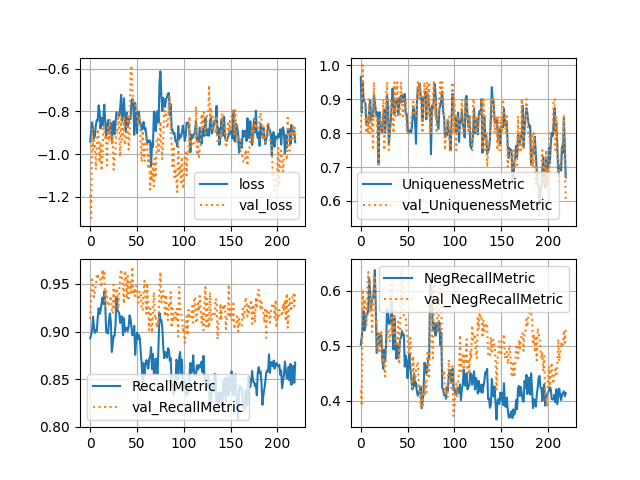

In [13]:
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]

axes = fig.subplots(int(len(lines)/2), 2)
for i in range(len(lines)):
    label = lines[i]
    ax = axes.flatten()[i]
    val_label = 'val_' + label
    
    

    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
        ax.grid()
    ax.legend()

    

recall: 0.67, precision: 0.76


<IPython.core.display.Javascript object>


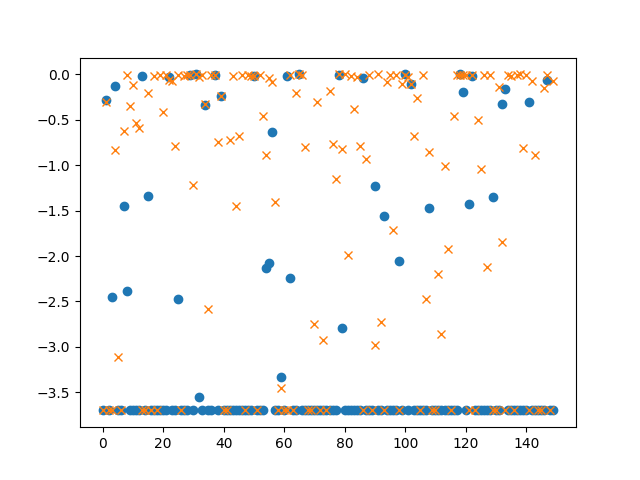

In [10]:


train_seqs = encoder_trainer.predict(train_inputs)
Yp = log_multisite_predictor(tf.gather(train_seqs, [0, 1], axis=1)).numpy()
Yn = log_multisite_predictor(tf.gather(train_seqs, [0, 2], axis=1)).numpy()

recall = (Yp > -2.0).sum() / len(train_inputs)
precision = (Yp > -2.0).sum() / ((Yp > -2.0).sum() + (Yn > -2.0).sum())
print(f"recall: {recall:.2f}, precision: {precision:.2f}")

loss = TripletLoss(3.0)(None, train_seqs)

plt.figure()

plt.plot(Yn, 'o')
plt.plot(Yp, 'x')

#plt.hlines(0.5, 0, len(train_seqs), linestyle=':')

recall: 0.76, precision: 0.84


<IPython.core.display.Javascript object>


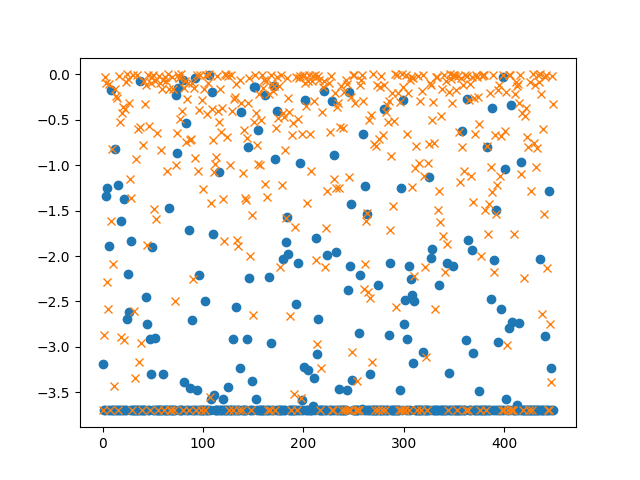

In [51]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(3, val_batch_generator)
val_seqs = encoder_trainer.predict(val_inputs)
# pos_distance = log10_crispr_spec(tf.gather(val_seqs, [0,1], axis=1))
# neg_distance = log10_crispr_spec(tf.gather(val_seqs, [0,2], axis=1))
Yp = log_multisite_predictor(tf.gather(val_seqs, [0, 1], axis=1)).numpy()
Yn = log_multisite_predictor(tf.gather(val_seqs, [0, 2], axis=1)).numpy()

recall = (Yp > -2.0).sum() / len(val_inputs)
precision = (Yp > -2.0).sum() / ((Yp > -2.0).sum() + (Yn > -2.0).sum())
print(f"recall: {recall:.2f}, precision: {precision:.2f}")

loss = TripletLoss(3.0)(None, train_seqs)

plt.figure()

plt.plot(Yn, 'o')
plt.plot(Yp, 'x')


<IPython.core.display.Javascript object>


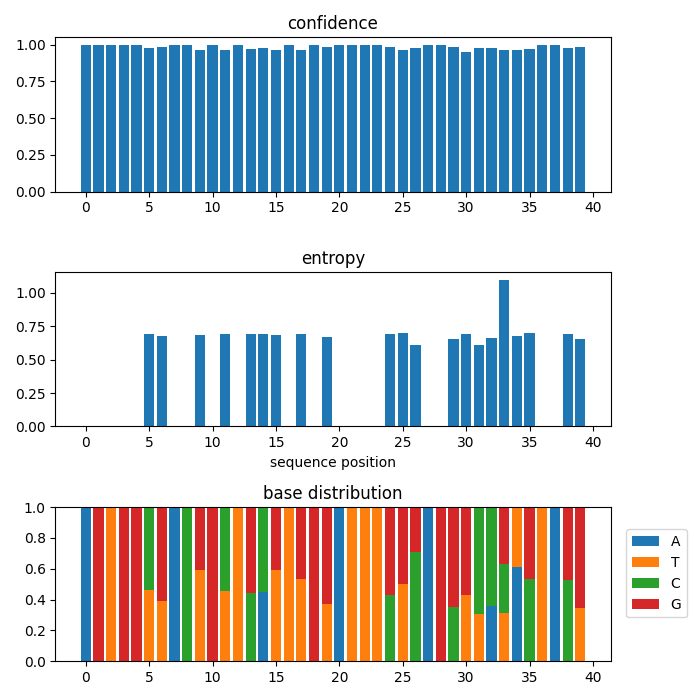

In [50]:
def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def base_distribution(sequences):
    one_hots = one_hot(sequences)
    bases = np.sum(one_hots, axis=0)

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth)) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

seqs_softmax = encoder_trainer.predict(train_inputs)[:, 0, :, :]
seqs_onehot = one_hot(seqs_softmax.argmax(-1))

base_distributions = seqs_onehot.sum(0) / len(oh)
seqlen = oh.shape[1]
ax = fig.add_subplot(111)
plt.tight_layout()

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure(figsize=[7, 7])
axes = fig.subplots(3,1)
ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')

ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')
ax.set_xlabel('sequence position')

ax = axes[2]
ax.set_title('base distribution')
bottom = np.zeros_like(base_distributions[:, 0])
ax.bar(np.arange(seqlen), base_distributions[:, 0], label='A', )
bottom += base_distributions[:, 0]
ax.bar(np.arange(seqlen), base_distributions[:, 1], label='T', bottom=bottom)
bottom += base_distributions[:, 1]
ax.bar(np.arange(seqlen), base_distributions[:, 2], label='C', bottom=bottom)
bottom += base_distributions[:, 2]
ax.bar(np.arange(seqlen), base_distributions[:, 3], label='G', bottom=bottom)
ax.legend(bbox_to_anchor=(1.15, 0.9))
#ax.set_xlim([0, seqlen])

plt.tight_layout()

<IPython.core.display.Javascript object>


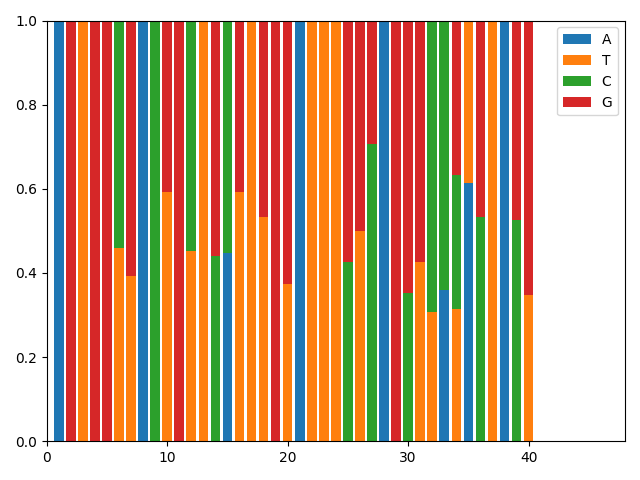

In [37]:
oh = one_hot(seqs_softmax.argmax(-1))
base_distributions = oh.sum(0) / len(oh)
fig = plt.figure()
ax = fig.add_subplot(111)
bottom = np.zeros_like(base_distributions[:, 0])
ax.bar(np.arange(1, oh.shape[1]+1), base_distributions[:, 0], label='A', )
bottom += base_distributions[:, 0]
ax.bar(np.arange(1, oh.shape[1]+1), base_distributions[:, 1], label='T', bottom=bottom)
bottom += base_distributions[:, 1]
ax.bar(np.arange(1, oh.shape[1]+1), base_distributions[:, 2], label='C', bottom=bottom)
bottom += base_distributions[:, 2]
ax.bar(np.arange(1, oh.shape[1]+1), base_distributions[:, 3], label='G', bottom=bottom)
ax.legend()
ax.set_xlim([0, oh.shape[1] + 8])
plt.tight_layout()

<IPython.core.display.Javascript object>


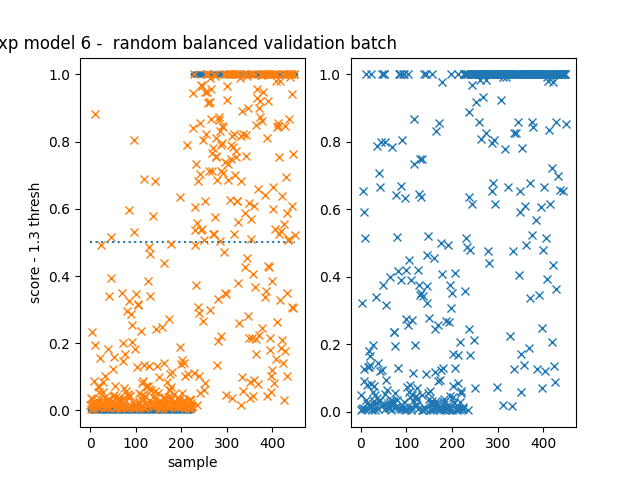

(450,)
(450,)


In [16]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(3, val_batch_generator)

idx = val_targets.argsort()

Y = encoder_trainer.predict(val_inputs)
Y2 = onehotscore.predict(val_inputs)
plt.figure()
plt.subplot(1, 2, 1)
print(val_targets.shape)
print((Y[:, 0] - val_targets).shape)

plt.plot(val_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')

plt.hlines(0.5, 0, len(Y), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 6 -  random balanced validation batch')
plt.subplot(1,2,2)
plt.plot(Y2[idx][:, 0], 'x')



In [160]:
seqs = calcseq.predict(train_inputs)
all_seqs = seqs[:, 0, :, :] #np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])

seq_strings = seqtools.onehots_to_seqs(all_seqs)
print(len(np.unique(all_seqs.argmax(-1), axis=0)))
unique = np.unique(seq_strings)
print(unique)
print(f"{len(unique)} / {len(all_seqs)}")



18
['AACCCAAAAGGTCTCCCAAT' 'AACTAAAAAGGTATCCCAAT' 'AAGCAAAACGGTCTCCCAAT'
 'AAGTAAAAAGGTATCCCAAT' 'AATAAAAAAGGTATCCCAAT' 'ACATAAAAAGGTATCCCAAT'
 'ACCCAAAAAGGTATCCCAAT' 'ACCTAAAAAGGTATCCCAAT' 'ACGTAAAAAGGTATCCCAAT'
 'AGAAAAAAAGGTATCCCAAT' 'AGACCAAACGGTCTCCCAAT' 'AGATAAAAAGGTATCCCAAT'
 'AGCAAAAAAGGTATCCCAAT' 'AGCCAAAAAGGTATCCCAAT' 'AGCTAAAAAGGTATCCCAAT'
 'AGGGCAAACGGTCTCCCAAT' 'AGGTAAAAAGGTATCCCAAT' 'ATTGTAAACGGTCTCCCAAT']
18 / 150


In [146]:
all_seqs[7]

array([[0.2884175 , 0.23601155, 0.23601155, 0.23955944],
       [0.25720426, 0.24759857, 0.24759857, 0.24759857],
       [0.24693605, 0.25148347, 0.2546444 , 0.24693605],
       [0.24139662, 0.24139662, 0.25321403, 0.2639927 ],
       [0.21311817, 0.29027724, 0.281361  , 0.21524361],
       [0.37172765, 0.20942414, 0.20942414, 0.20942414],
       [0.36570013, 0.19783144, 0.20422493, 0.23224354],
       [0.36660382, 0.21478833, 0.20077096, 0.21783693],
       [0.24842957, 0.24842957, 0.24842957, 0.25471133],
       [0.2187479 , 0.226001  , 0.21555598, 0.3396952 ],
       [0.22710787, 0.23759168, 0.24019796, 0.29510248],
       [0.21209948, 0.3627353 , 0.21209948, 0.21306576],
       [0.20428705, 0.2545349 , 0.31877866, 0.22239937],
       [0.21433549, 0.36028582, 0.2119558 , 0.21342291],
       [0.24048308, 0.21929534, 0.32545286, 0.21476874],
       [0.2164845 , 0.20996463, 0.36358628, 0.20996463],
       [0.23047075, 0.23644206, 0.31387344, 0.21921377],
       [0.34276912, 0.23512419,

In [9]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    pred = encoder_trainer(train_inputs)
    loss = tf.metrics.MSE(train_targets,pred)
    
# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

[<tf.Tensor: shape=(4096, 2048), dtype=float32, numpy=
array([[-0.00668996, -0.00442752, -0.01292114, ..., -0.00297812,
         0.00866672,  0.00046856],
       [-0.014083  , -0.0085131 , -0.01540488, ..., -0.00662993,
         0.01435623,  0.00218737],
       [-0.00739208, -0.00459306, -0.00793888, ..., -0.00424623,
         0.00936238,  0.00140106],
       ...,
       [-0.00707141, -0.0031601 , -0.00536229, ..., -0.00655378,
         0.01212534,  0.0022773 ],
       [-0.01130053, -0.00968682, -0.01601881, ..., -0.00374336,
         0.00950455,  0.00092499],
       [-0.00697468, -0.0061232 , -0.00847617, ..., -0.0014009 ,
         0.00568788,  0.00132537]], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01711289, -0.01263236, -0.01965856, ..., -0.00607363,
        0.01729374,  0.0022029 ], dtype=float32)>, <tf.Tensor: shape=(2048, 2048), dtype=float32, numpy=
array([[ 5.5676320e-04,  7.4185044e-02,  7.9013333e-02, ...,
        -1.9020287e-02, -2.8113823e-

In [10]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>

In [11]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [ ]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

In [ ]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

In [ ]:
print(np.around(all_seqs[0], 4))